# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [3]:
import pickle

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [14]:
df = pd.read_csv("../Data/banerjee_miracle.csv")

df.head()

,male_head,anyloan_amt,female_biz_pct,bizexpense,total_exp_mo,home_durable_index,anyloan_amt_2,informal_amt_2,female_biz_pct_2,hours_week_2,durables_exp_mo_2,temptation_exp_mo_2,total_exp_mo_2,bizprofit_2,bizrev_2,bizemployees_2,girls_school
0,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
1,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
2,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
3,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN
4,2.0,2,2.0,2,2,2,5000.0,0.0,0.0,36.0,1291.1173,0.0,11836.075,2049.1282,2498.9368,0.0,NaN


In [15]:
cols = df.columns
outcome_cols = cols[6:]

In [255]:
outcome_col_id = 16
outcome_col = cols[outcome_col_id]

print(f"Outcome is {outcome_col}")

df2 = df.copy()
df2[outcome_col] = df[outcome_col].fillna(0)

Z = df2.to_numpy()



# X = Z[:, [0, 1, 2, 3, 4]]
X = Z[:, [0, 2, 3, 4, 5]]
y = Z[:, outcome_col_id]
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

Outcome is girls_school
There are 2800 data points


# Analysis

In [256]:
M = 5
R = np.array([3, 3, 4, 4, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [257]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [258]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

1.0


(array([264]),)

In [261]:
reg = 1e-6
q =  1e-5
# H = 20
H = np.inf
R_set, rashomon_profiles = RAggregate(M, R, H, D, y, q, reg=reg)
# R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encountered in divide
  mu = np.float64(policy_means_k[:, 0]) / policy_means_k[:, 1]
/Users/apara/Documents/Research/2022_Bayesian_TVA/Rashomon/Code/rashomon/aggregate/raggregate.py:46: RuntimeWarning: invalid value encou

(1, 1, 0, 0, 0) 1e-05
4
(1, 1, 0, 0, 1) 1e-05
15
(1, 1, 0, 1, 0) 1e-05
15
(1, 1, 0, 1, 1) 1e-05
43
(1, 1, 1, 1, 1) 1e-05
96
Finding feasible combinations
14337


In [262]:
model_losses = []

for r_set in R_set:
    loss_r = 0
    for profile, model_prof in enumerate(r_set):
        loss_r_prof = rashomon_profiles[profile].loss[model_prof]
        loss_r += loss_r_prof
    
    model_losses.append(loss_r)

q0 = np.min(model_losses)
eps = (np.max(model_losses) - np.min(model_losses)) / q0

print(f"Best model loss {q0} and epsilon {eps}")

Best model loss 4.9999999999999996e-06 and epsilon 1.0000000000000004


In [263]:
res_dict = {
    "outcome": outcome_col,
    "reg": reg,
    "q": q,
    "q0": q0,
    "eps": eps,
    "H": H,
    "R_set": R_set,
    "R_profiles": rashomon_profiles
}

In [264]:
pkl_fname = "../Results/microfinance/" + outcome_col + ".pkl"

with open(pkl_fname, "wb") as f:
    pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

print("Done pickling!")

Done pickling!


## Plots

In [265]:
results_dir = "../Results/microfinance/"
# outcome_str = "durables_exp_mo_2"
outcome_str = outcome_col

outcome_fname = results_dir + outcome_str + ".pkl"

In [266]:
with open(outcome_fname, "rb") as f:
    res_dict = pickle.load(f)

reg = res_dict["reg"]
q = res_dict["q"]
q0 = res_dict["q0"]
eps = res_dict["eps"]
H = res_dict["H"]
R_set = res_dict["R_set"]
R_profiles = res_dict["R_profiles"]

print(reg, q, q0, eps)

1e-06 1e-05 4.9999999999999996e-06 1.0000000000000004


In [271]:
# Find active profiles

for k, R_profile in enumerate(R_profiles):
    if len(R_profile) == 1:
        if R_profile.sigma[0] is None:
            continue

    print(profiles[k]) #, R_profile.sigma[0].shape)
    for sigma in R_profile.sigma:
        sigma_temp = sigma.copy()
        sigma_temp[np.isinf(sigma_temp)] = 1
        if np.all(np.equal(sigma_temp, 1)):
            print("Flat!")

(1, 1, 0, 0, 0)
Flat!
(1, 1, 0, 0, 1)
Flat!
(1, 1, 0, 1, 0)
Flat!
(1, 1, 0, 1, 1)
Flat!
(1, 1, 1, 1, 1)
Flat!


In [276]:
M = 5
R = np.array([3, 4, 3, 4, 4])
features = ["Male Head", "Female Biz", "Biz expense", "Total expense", "Durable Index"]

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

In [297]:
feature_splits = np.array([0] * len(features), dtype=np.float64)
profile_splits = np.array([0] * num_profiles)

for r, model_r in enumerate(R_set):

    feature_splits_r = np.zeros(shape=feature_splits.shape)
    feature_present_r = np.zeros(shape=feature_splits.shape, dtype=np.float64)
    
    for k, sigma_k_idx in enumerate(model_r):
        sigma_k = R_profiles[k].sigma[sigma_k_idx]
        if sigma_k is None:
            continue
            
        features_k = [features[j] for j, val in enumerate(profiles[k]) if val == 1]
        
        sigma_temp = sigma_k.copy()
        sigma_temp[np.isinf(sigma_temp)] = 0
        profile_splits[k] += np.sum(sigma_temp)

        row_id = 0
        for j, present in enumerate(profiles[k]):
            if present == 1:
                feature_splits_r[j] += np.sum(sigma_temp[row_id, :])
                feature_present_r[j] += 1
                row_id += 1

    feature_splits += np.divide(feature_splits_r, feature_present_r)


profile_splits = profile_splits / len(R_set)
feature_splits = feature_splits / len(R_set)

feature_splits = feature_splits.reshape((1, -1))
profile_splits = profile_splits.reshape((1, -1))

print(feature_splits)
print(profile_splits)

[[0.83110832 0.83110832 1.70691219 1.651345   1.64888052]]
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.54509312 3.23261491 3.24098486 5.03173607 0.         0.
  0.         6.86824301]]


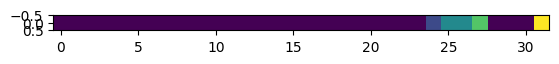

In [301]:
plt.imshow(profile_splits)

plt.show()

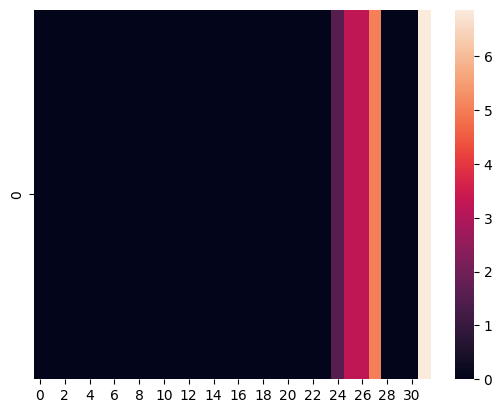

In [305]:

sns.heatmap(profile_splits, annot=False)

plt.show()